# Convert units from CESM2 experiment output to forms read by NEMO

Variables available etc.: https://docs.google.com/spreadsheets/u/1/d/1OPcJsTcpaxBVZqcRpEEf16cipuL3CUk2nWojQ_ulRjE/edit?gid=0#gid=0

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
import cf
import cmocean
sys.path.append('/home/users/birgal/')
from nemo_python_git.file_io import find_cesm2_file
from nemo_python_git.forcing import cesm2_expt_all_atm_forcing, cesm2_expt_all_ocn_forcing
from nemo_python_git.interpolation import interp_latlon_cf
from nemo_python_git.utils import fix_lon_range

In [3]:
import glob

In [ ]:
ds1 = xr.open_dataset(f'{cesm2_folder}LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.FLDS.18500101-18591231.nc')['FLDS'].isel(time=0)
ds2 = xr.open_dataset(f'{cesm2_folder}LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.FSDS.18500101-18591231.nc')['FSDS'].isel(time=0)
ds3 = xr.open_dataset(f'{cesm2_folder}LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.TREFHT.18500101-18591231.nc')['TREFHT'].isel(time=0)
ds4 = xr.open_dataset(f'{cesm2_folder}LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.QREFHT.18500101-18591231.nc')['QREFHT'].isel(time=0)
ds5 = xr.open_dataset(f'{cesm2_folder}LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.PSL.18500101-18591231.nc')['PSL'].isel(time=0)
ds6 = xr.open_dataset(f'{cesm2_folder}LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.PRECT.18500101-18591231.nc')['PRECT'].isel(time=0)

In [1]:
# ds1.plot(figsize=(16,5), ylim=(-90, -50))
# ds2.plot(figsize=(16,5), ylim=(-90, -50))
# ds3.plot(figsize=(16,5), ylim=(-90, -50))
# ds4.plot(figsize=(16,5), ylim=(-90, -50))
# ds5.plot(figsize=(16,5), ylim=(-90, -50))
# ds6.plot(figsize=(16,5), ylim=(-90, -50), vmin=0, vmax=1e-7)

Lowest atmospheric model level grid cell is not actually the same as the 10 m wind level (closer to 50-100 m; 992 hPa). What did Paul + Kaitlin and Kat do for their model runs? One option would be:
- Use U10 variable for wind speed magnitude and UBOT, VBOT for wind speed direction

$ U_{10}^2 = U_x^2 + U_y^2$

$ U_x = U_{10} \cdot \cos(\theta) $

$ U_y = U_{10} \cdot \sin(\theta) $

$\theta = \tan^{-1}(\frac{U_{BOTy}}{U_{BOTx}})$

In [ ]:
fig, ax =plt.subplots(1,3, figsize=(18,5))
U10.plot(ylim=(-90,-50), ax=ax[0], vmin=0, vmax=30)
((UBOT**2 + VBOT**2)**0.5).plot(ylim=(-90,-50), ax=ax[1], vmin=0, vmax=30)
(U10-((UBOT**2 + VBOT**2)**0.5)).plot(ylim=(-90,-50), ax=ax[2])

In [ ]:
fig, ax =plt.subplots(2,2, figsize=(16,10))
UBOT.plot(ylim=(-90,-50), ax=ax[0,0], vmin=-30, vmax=30, cmap=cmocean.cm.balance)
VBOT.plot(ylim=(-90,-50), ax=ax[0,1], vmin=-30, vmax=30, cmap=cmocean.cm.balance)
Ux.plot(ylim=(-90,-50), ax=ax[1,0], vmin=-30, vmax=30, cmap=cmocean.cm.balance)
Vx.plot(ylim=(-90,-50), ax=ax[1,1], vmin=-30, vmax=30, cmap=cmocean.cm.balance)

In [ ]:
fig, ax =plt.subplots(2,2, figsize=(16,10))
(U10 - ((UBOT**2 + VBOT**2)**0.5)).plot(ylim=(-90,-50), ax=ax[0,0], vmin=-5, vmax=5, cmap=cmocean.cm.balance)
(U10 - U10_recreate).plot(ylim=(-90,-50), ax=ax[0,1], vmin=-1, vmax=1, cmap=cmocean.cm.balance)
(UBOT - Ux).plot(ylim=(-90,-50), ax=ax[1,0], vmin=-5, vmax=5, cmap=cmocean.cm.balance)
(VBOT - Vx).plot(ylim=(-90,-50), ax=ax[1,1], vmin=-5, vmax=5, cmap=cmocean.cm.balance)

ax[0,0].set_title('Difference between U10 and UBOT,VBOT')
ax[0,1].set_title('Difference between U10 and U recreated')
ax[1,0].set_title('Difference between UBOT and U10x')
ax[1,1].set_title('Difference between VBOT and U10y')

In [5]:
# Convert wind velocities from lowest atmospheric model level grid cell to the 10 m wind level 
# (CESM2 output UBOT and VBOT which is at 992 hPa) by using 'U10', the 10 m wind speed and the wind directions from UBOT and VBOT
def UBOT_to_U10_wind(Ubottom, Vbottom, U10_mag):

    # calculate the angle between the UBOT and VBOT wind vectors
    theta = np.arctan2(Vbottom, Ubottom) 
    # then use this angle to create the x and y wind vector components that sum to the magnitude of the U10 wind speed
    Ux = U10_mag*np.cos(theta)
    Uy = U10_mag*np.sin(theta)

    # check that the differences between U10 speed and recreated U10 speed are small:
    U10_recreate = np.sqrt(Ux**2 + Uy**2)
    if np.max(np.abs(U10 - U10_recreate)) > 0.1: 
        raise Exception('The maximum difference between the provided U10 wind speed and the recreated speed' + \
                        'is greater than 0.1 m/s. Double check that wind velocities were recreated correctly.')

    return Ux, Uy

In [55]:
time_ind=100

cesm2_folder = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/'
U10  = xr.open_dataset(f'{cesm2_folder}LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.U10.18500101-18591231.nc')['U10'].isel(time=time_ind)
UBOT = xr.open_dataset(f'{cesm2_folder}LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.UBOT.18500101-18591231.nc')['UBOT'].isel(time=time_ind)
VBOT = xr.open_dataset(f'{cesm2_folder}LE2/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.VBOT.18500101-18591231.nc')['VBOT'].isel(time=time_ind)
UBOTf = UBOT.copy(); VBOTf = VBOT.copy();
UBOTf['lon'] = fix_lon_range(UBOT['lon'])
VBOTf['lon'] = fix_lon_range(VBOT['lon'])

cesm2_folder2 = f'{cesm2_folder}LE2/processed/'
U10x = xr.open_dataset(f'{cesm2_folder2}CESM2-LE2_ens1011.001_U10x_y1850.nc')['U10x'].isel(time=time_ind)
U10y = xr.open_dataset(f'{cesm2_folder2}CESM2-LE2_ens1011.001_U10y_y1850.nc')['U10y'].isel(time=time_ind)

Ux, Uy = UBOT_to_U10_wind(UBOT, VBOT, U10)
Ux['lon'] = fix_lon_range(Ux['lon'])
Uy['lon'] = fix_lon_range(Uy['lon'])

In [ ]:
fig, ax =plt.subplots(1,3, figsize=(18,4))
ax[0].set_title('Original U10 magnitude')
ax[1].set_title('Original bottom magnitude')
ax[2].set_title('Difference')
U10.plot(ylim=(-90,-50), ax=ax[0], vmin=0, vmax=30)
((UBOT**2 + VBOT**2)**0.5).plot(ylim=(-90,-50), ax=ax[1], vmin=0, vmax=30)
(U10-((UBOT**2 + VBOT**2)**0.5)).plot(ylim=(-90,-50), ax=ax[2])

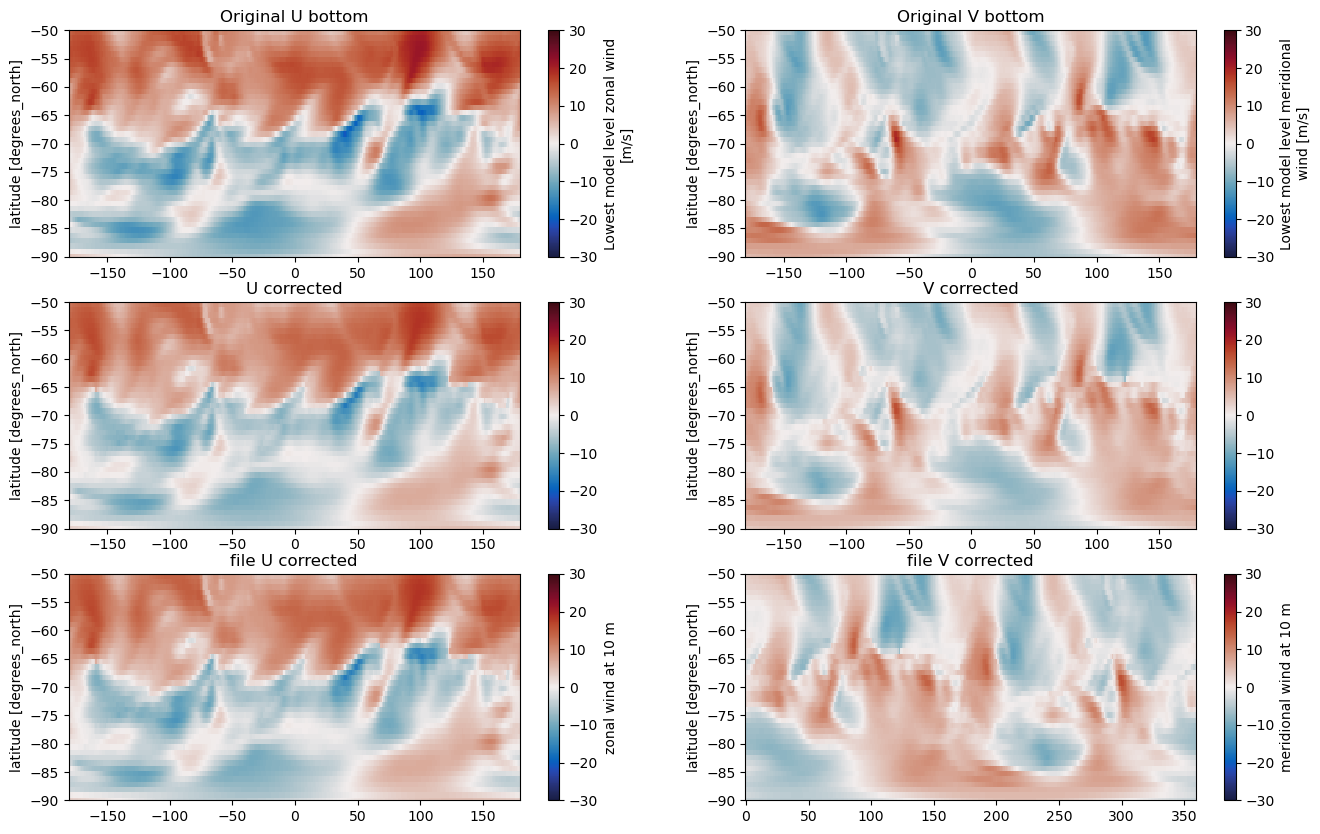

In [56]:
fig, ax =plt.subplots(3,2, figsize=(16,10))
UBOTf.sortby('lon').plot(ylim=(-90,-50), ax=ax[0,0], vmin=-30, vmax=30, cmap=cmocean.cm.balance)
VBOTf.sortby('lon').plot(ylim=(-90,-50), ax=ax[0,1], vmin=-30, vmax=30, cmap=cmocean.cm.balance)
Ux.sortby('lon').plot(ylim=(-90,-50), ax=ax[1,0], vmin=-30, vmax=30, cmap=cmocean.cm.balance)
Uy.sortby('lon').plot(ylim=(-90,-50), ax=ax[1,1], vmin=-30, vmax=30, cmap=cmocean.cm.balance)
U10x.sortby('lon').plot(ylim=(-90,-50), ax=ax[2,0], vmin=-30, vmax=30, cmap=cmocean.cm.balance)
U10y.sortby('lon').plot(ylim=(-90,-50), ax=ax[2,1], vmin=-30, vmax=30, cmap=cmocean.cm.balance)

ax[0,0].set_title('Original U bottom'); ax[0,1].set_title('Original V bottom');
ax[1,0].set_title('U corrected');       ax[1,1].set_title('V corrected');
ax[2,0].set_title('file U corrected');  ax[2,1].set_title('file V corrected');
for axis in ax.ravel():
    axis.set_xlabel('')

In [139]:
# print(Ux.min().values, Ux.max().values)
# print(Vx.min().values, Vx.max().values)
# print(UBOT.min().values, UBOT.max().values)
# print(VBOT.min().values, VBOT.max().values)
# print(UBOTp.min().values, UBOTp.max().values)
# print(VBOTp.min().values, VBOTp.max().values)

In [5]:
glob.glob('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/piControl/b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.h1.FSDS.1850*')

['/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/piControl/b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.h1.FSDS.18500101-18591231.nc']

In [2]:
ds = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/CESM2-LE2_ens1011.001_SALT_y1850.nc')

In [2]:
out_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'
cesm2_expt_all_atm_forcing('LE2', ens_strs=['1011.001'], out_dir=out_dir, start_year=1850, end_year=1860)

Processing ensemble member 1011.001
Processing PRECS


In [2]:
out_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'
cesm2_expt_all_ocn_forcing('LE2', ens_strs=['1011.001'], out_dir=out_dir, start_year=1850, end_year=1860)

Processing ensemble member 1011.001
Processing aice
Processing sithick
Processing sisnthick


In [3]:
nemoT = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test6/files/eANT025.L121_1m_19790101_19791231_grid_T.nc')

In [8]:
nemoT_ds = nemoT[['thetao','nav_lon_grid_T','nav_lat_grid_T']].rename({'x_grid_T':'x','y_grid_T':'y',
                                                                       'nav_lon_grid_T':'nav_lon','nav_lat_grid_T':'nav_lat'})
nemoT_ds = nemoT_ds.isel(time_counter=0)

### Test cf-python regridding of CESM2 conditions

In [2]:
domcfg   = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc')
meshmask = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc')

In [17]:
climate_forcing = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'
cesm2_temp = xr.open_dataset(f'{climate_forcing}CESM2-LE2_ens1011.001_TREFHT_y1850.nc')
cesm2_ocn  = xr.open_dataset(f'{climate_forcing}CESM2-LE2_ens1011.001_TEMP_y1850.nc')
cesm2_salt = xr.open_dataset(f'{climate_forcing}CESM2-LE2_ens1011.001_SALT_y1850.nc')

In [4]:
start_cesm2 = cesm2_ocn.isel(time=0).rename({'TLONG':'lon', 'TLAT':'lat'})#, 'nlon':'lon', 'nlat':'lat'})
cesm2_lon_E = fix_lon_range(start_cesm2['lon'])
start_cesm2['lon'] = cesm2_lon_E
start_cesm2['z_t'] = start_cesm2['z_t']*1e-2
start_cesm2_sub    = start_cesm2.isel(nlon=slice(200,280), nlat=slice(0,70), z_t=slice(0,1))

In [79]:
nemo_mesh     = meshmask.isel(time_counter=0)
nemo_mesh_sub = meshmask.isel(time_counter=0, x=slice(500,800), y=slice(150,None), nav_lev=slice(0,1))
dummy_data    = np.zeros([nemo_mesh_sub.sizes['nav_lev'], nemo_mesh_sub.sizes['y'], nemo_mesh_sub.sizes['x']])
nemo_mesh_sub = nemo_mesh_sub.assign_coords({'z_t':start_cesm2_sub['z_t']}).drop_vars('nav_lev').rename({'z_t':'nav_lev'})

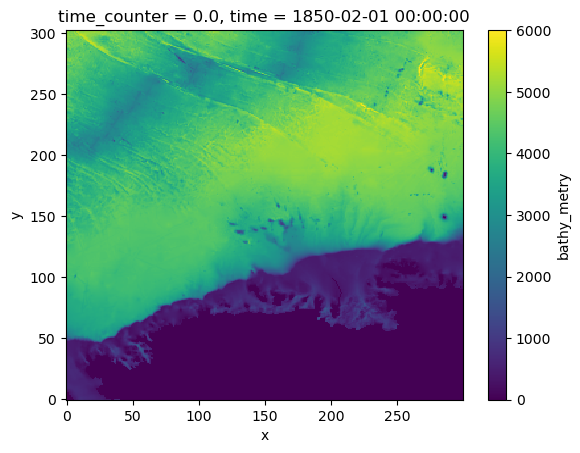

In [80]:
nemo_mesh_sub.bathy_metry.plot()

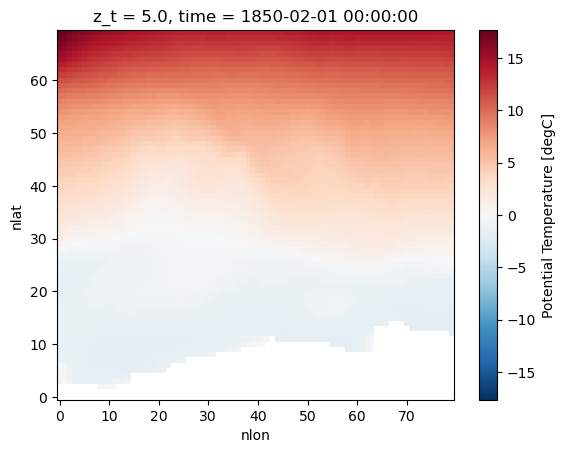

In [28]:
start_cesm2_sub.ConsTemp.isel(z_t=0).plot()

In [3]:
# Helper function to construct a minimal CF field so cf-python can do regridding.
# Mostly following Robin Smith's Unicicles coupling code in UKESM.
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
def construct_cf_2d (data, x, y, lon=None, lat=None, lon_bounds=None, lat_bounds=None):

    native_latlon = lon is None and lat is None
    print(native_latlon)

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    lon = convert_np(lon)
    lat = convert_np(lat)
    lon_bounds = convert_np(lon_bounds)
    lat_bounds = convert_np(lat_bounds)

    field = cf.Field()

    if native_latlon:
        dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'degrees_east'), properties={'axis':'X', 'standard_name':'longitude'})
        dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'degrees_north'), properties={'axis':'Y', 'standard_name':'latitude'})
        if lon_bounds is not None:
            dim_x.set_bounds(cf.Bounds(data=cf.Data(lon_bounds, 'degrees_east')))
        if lat_bounds is not None:
            dim_y.set_bounds(cf.Bounds(data=cf.Data(lat_bounds, 'degrees_north')))
    else:
        dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'))
        dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'))
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')

    if not native_latlon:
        dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
        if lon_bounds is not None:
            dim_lon.set_bounds(cf.Bounds(data=cf.Data(lon_bounds, 'degrees_east')))
        field.set_construct(dim_lon, axes=('Y','X'))
        dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
        if lat_bounds is not None:
            dim_lat.set_bounds(cf.Bounds(data=cf.Data(lat_bounds, 'degrees_north')))
        field.set_construct(dim_lat, axes=('Y','X'))
    field.set_data(cf.Data(data), axes=('Y', 'X'))
    return field

In [4]:
# Helper function to construct a minimal CF field so cf-python can do regridding.
# Mostly following Robin Smith's Unicicles coupling code in UKESM.
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
def construct_cf_2d3d (data, x, y, z, lon=None, lat=None, lon_bounds=None, lat_bounds=None):

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    z = convert_np(z)
    lon = convert_np(lon)
    lat = convert_np(lat)
    lon_bounds = convert_np(lon_bounds)
    lat_bounds = convert_np(lat_bounds)

    field = cf.Field()

    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'), properties={'axis':'X'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'), properties={'axis':'Y'})
    dim_z = cf.DimensionCoordinate(data=cf.Data(z, 'm'), properties={'axis':'Z'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')
    field.set_construct(cf.DomainAxis(size=z.size), key='Z')
    field.set_construct(dim_z, axes='Z')

    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))
    # dim_dep = cf.AuxiliaryCoordinate(data=cf.Data(z, 'meters'), properties={'standard_name':'depth'})
    # field.set_construct(dim_dep, axes=('Z'))
        
    field.set_data(cf.Data(data), axes=('Z','Y','X'))
    return field

In [5]:
# Helper function to construct a minimal CF field so cf-python can do regridding.
# Mostly following Robin Smith's Unicicles coupling code in UKESM.
# If the coordinate axes (1D) x and y are not lat-lon, pass in auxiliary lat-lon values (2D).
def construct_cf_3d2d (data, x, y, lon=None, lat=None, lon_bounds=None, lat_bounds=None):

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    lon = convert_np(lon)
    lat = convert_np(lat)
    lon_bounds = convert_np(lon_bounds)
    lat_bounds = convert_np(lat_bounds)

    field = cf.Field()

    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'm'), properties={'axis':'X'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'm'), properties={'axis':'Y'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')

    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))
        
    field.set_data(cf.Data(data), axes=('Y','X'))
    return field

In [8]:
def construct_cf_3d (data, x, y, z, lon=None, lat=None, depth=None):

    # Inner function to convert to np arrays if needed
    def convert_np (var):
        if isinstance(var, xr.DataArray):
            var = var.data
        return var
    data = convert_np(data)
    x = convert_np(x)
    y = convert_np(y)
    z = convert_np(z)
    lon = convert_np(lon)
    lat = convert_np(lat)
    depth = convert_np(depth)
    
    field = cf.Field()
    dim_x = cf.DimensionCoordinate(data=cf.Data(x, 'degrees_east'), properties={'axis':'X', 'standard_name':'longitude'})
    dim_y = cf.DimensionCoordinate(data=cf.Data(y, 'degrees_north'), properties={'axis':'Y', 'standard_name':'latitude'})
    dim_z = cf.DimensionCoordinate(data=cf.Data(z, 'meters'), properties={'axis':'Z', 'standard_name':'depth'})
    field.set_construct(cf.DomainAxis(size=x.size), key='X')
    field.set_construct(dim_x, axes='X')
    field.set_construct(cf.DomainAxis(size=y.size), key='Y')
    field.set_construct(dim_y, axes='Y')
    field.set_construct(cf.DomainAxis(size=z.size), key='Z')
    field.set_construct(dim_z, axes='Z')
    
    dim_lon = cf.AuxiliaryCoordinate(data=cf.Data(lon, 'degrees_east'), properties={'standard_name':'longitude'})
    field.set_construct(dim_lon, axes=('Y','X'))
    dim_lat = cf.AuxiliaryCoordinate(data=cf.Data(lat, 'degrees_north'), properties={'standard_name':'latitude'})
    field.set_construct(dim_lat, axes=('Y','X'))
    # dim_dep = cf.AuxiliaryCoordinate(data=cf.Data(depth, 'meters'), properties={'standard_name':'depth'})
    # field.set_construct(dim_dep, axes=('Z','Y','X'))

    field.set_data(cf.Data(data), axes=('Z', 'Y', 'X'))
    return field

In [10]:
start_cesm2 = cesm2_ocn.isel(time=0).rename({'TLONG':'lon', 'TLAT':'lat'})#, 'nlon':'lon', 'nlat':'lat'})
cesm2_lon_E = fix_lon_range(start_cesm2['lon'])
start_cesm2['lon'] = cesm2_lon_E
start_cesm2['z_t'] = start_cesm2['z_t']*1e-2
start_cesm2_sub    = start_cesm2.isel(nlon=slice(200,280), nlat=slice(0,70))

nemo_mesh     = meshmask.isel(time_counter=0)
nemo_mesh_sub = meshmask.isel(time_counter=0, x=slice(500,800), y=slice(150,None), nav_lev=slice(0,10))
dummy_data    = np.zeros([nemo_mesh_sub.sizes['nav_lev'], nemo_mesh_sub.sizes['y'], nemo_mesh_sub.sizes['x']])

src_sub = construct_cf_2d3d(start_cesm2_sub['ConsTemp'], start_cesm2_sub['nlon'], start_cesm2_sub['nlat'], start_cesm2_sub['z_t'],
                          lon=start_cesm2_sub['lon'], lat=start_cesm2_sub['lat'])
dst_sub = construct_cf_2d3d(nemo_mesh_sub['e3t_0'], nemo_mesh_sub['x'], nemo_mesh_sub['y'], nemo_mesh_sub['nav_lev'],
                          lon=nemo_mesh_sub['nav_lon'], lat=nemo_mesh_sub['nav_lat'])

src_regrid = src_sub.regrids(dst_sub, method='linear', src_z='Z', dst_z='Z', ln_z=False, 
                             dst_axes={'X':'X','Y':'Y','Z':'Z'}, src_axes={'X':'X','Y':'Y','Z':'Z'}, use_dst_mask=True,
                             src_cyclic=False, dst_cyclic=False, return_operator=True)

# ds = src_regrid.array

In [20]:
start_cesm2 = cesm2_salt.isel(time=0).rename({'TLONG':'lon', 'TLAT':'lat'})#, 'nlon':'lon', 'nlat':'lat'})
cesm2_lon_E = fix_lon_range(start_cesm2['lon'])
start_cesm2['lon'] = cesm2_lon_E
start_cesm2['z_t'] = start_cesm2['z_t']*1e-2
start_cesm2_sub    = start_cesm2.isel(nlon=slice(200,280), nlat=slice(0,70))

src_sub2 = construct_cf_2d3d(start_cesm2_sub['SALT'], start_cesm2_sub['nlon'], start_cesm2_sub['nlat'], start_cesm2_sub['z_t'],
                             lon=start_cesm2_sub['lon'], lat=start_cesm2_sub['lat'])

In [27]:
import pickle

In [28]:
filename = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/cf-regridding/regrid-CESM2-eANT025-test.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(src_regrid, handle)

In [30]:
with open(filename, 'rb') as handle:
    b= pickle.load(handle)

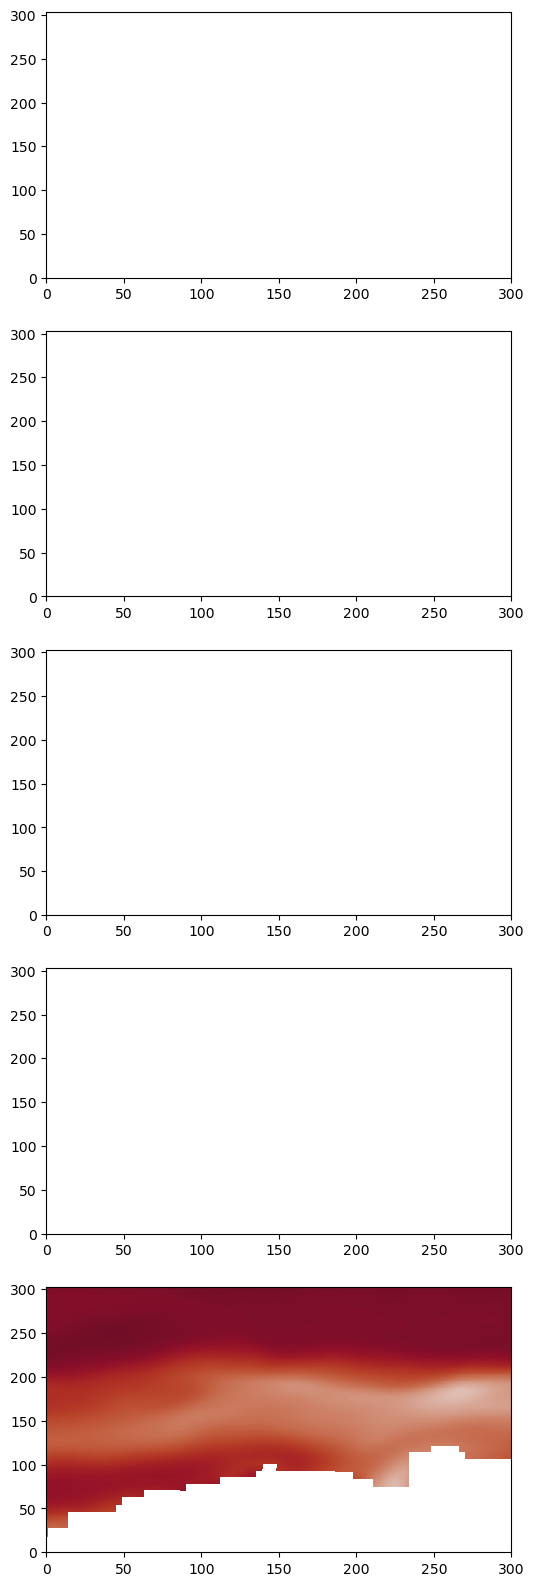

In [25]:
fig, ax = plt.subplots(5,1, figsize=(6,20))
for i in range(0,5):
    ax[i].pcolormesh(ds.array[i,:,:], vmin=30, vmax=34, cmap=cmocean.cm.balance)

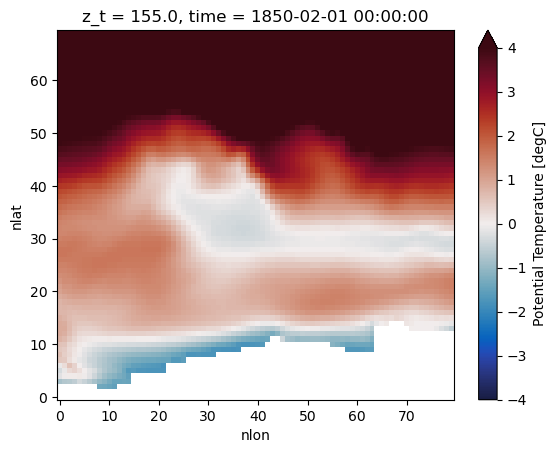

In [25]:
start_cesm2_sub.isel(z_t=15).ConsTemp.plot(vmin=-4, vmax=4, cmap=cmocean.cm.balance)

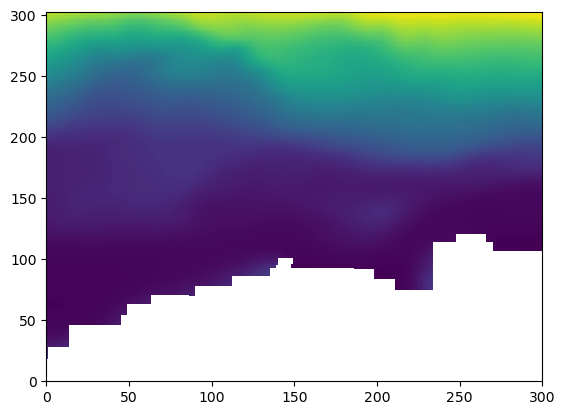

In [151]:
start_cesm2 = cesm2_ocn.isel(time=0).rename({'TLONG':'lon', 'TLAT':'lat'})#, 'nlon':'lon', 'nlat':'lat'})
cesm2_lon_E = fix_lon_range(start_cesm2['lon'])
start_cesm2['lon'] = cesm2_lon_E
start_cesm2['z_t'] = start_cesm2['z_t']*1e-2
start_cesm2_sub    = start_cesm2.isel(nlon=slice(200,280), nlat=slice(0,70), z_t=0)

nemo_mesh     = meshmask.isel(time_counter=0)
nemo_mesh_sub = meshmask.isel(time_counter=0, x=slice(500,800), y=slice(150,None), nav_lev=0)
dummy_data    = np.zeros([nemo_mesh_sub.sizes['y'], nemo_mesh_sub.sizes['x']])

src_sub = construct_cf_3d2d(start_cesm2_sub['ConsTemp'], start_cesm2_sub['nlon'], start_cesm2_sub['nlat'],
                          lon=start_cesm2_sub['lon'], lat=start_cesm2_sub['lat'])
dst_sub = construct_cf_3d2d(nemo_mesh_sub['e3t_0'], nemo_mesh_sub['x'], nemo_mesh_sub['y'],
                          lon=nemo_mesh_sub['nav_lon'], lat=nemo_mesh_sub['nav_lat'])

src_regrid = src_sub.regrids(dst_sub, method='linear',
                             dst_axes={'X':'X','Y':'Y'}, src_axes={'X':'X','Y':'Y'}, use_dst_mask=True,
                             src_cyclic=False, dst_cyclic=False)

ds = src_regrid.array
plt.pcolormesh(ds[:,:])

#### Fill areas that are land in CESM2 but ocean in NEMO configuration with nearest ocean values

In [51]:
cesm2_temp_interp = interp_latlon_cf(cesm2_temp.isel(time=0), meshmask.isel(time_counter=0), method='bilinear')

[  0.     1.25   2.5    3.75   5.     6.25   7.5    8.75  10.    11.25
  12.5   13.75  15.    16.25  17.5   18.75  20.    21.25  22.5   23.75
  25.    26.25  27.5   28.75  30.    31.25  32.5   33.75  35.    36.25
  37.5   38.75  40.    41.25  42.5   43.75  45.    46.25  47.5   48.75
  50.    51.25  52.5   53.75  55.    56.25  57.5   58.75  60.    61.25
  62.5   63.75  65.    66.25  67.5   68.75  70.    71.25  72.5   73.75
  75.    76.25  77.5   78.75  80.    81.25  82.5   83.75  85.    86.25
  87.5   88.75  90.    91.25  92.5   93.75  95.    96.25  97.5   98.75
 100.   101.25 102.5  103.75 105.   106.25 107.5  108.75 110.   111.25
 112.5  113.75 115.   116.25 117.5  118.75 120.   121.25 122.5  123.75
 125.   126.25 127.5  128.75 130.   131.25 132.5  133.75 135.   136.25
 137.5  138.75 140.   141.25 142.5  143.75 145.   146.25 147.5  148.75
 150.   151.25 152.5  153.75 155.   156.25 157.5  158.75 160.   161.25
 162.5  163.75 165.   166.25 167.5  168.75 170.   171.25 172.5  173.75
 175. 

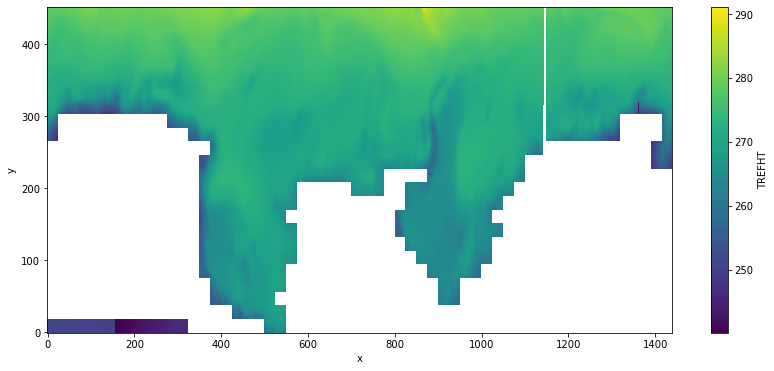

In [22]:
cesm2_temp_interp.TREFHT.plot(figsize=(14,6))

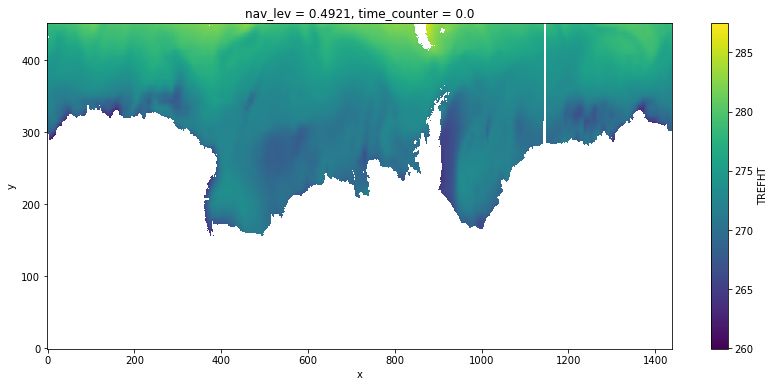

In [21]:
cesm2_temp_interp.TREFHT.where(meshmask.tmask.isel(time_counter=0, nav_lev=0)).plot(figsize=(14,6))

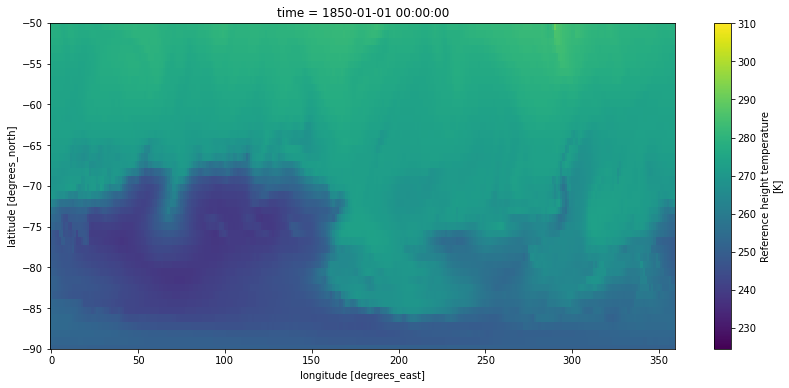

In [6]:
cesm2_temp.isel(time=0).TREFHT.plot(figsize=(14,6), ylim=(-90, -50))

In [ ]:
meshmask.tmask.isel(deptht=0).plot(figsize=(14,6))

In [ ]:
ocean_needs_to_be_filled = xr.where((meshmask.tmask == 0)*(cesm2_temp_interp.TREFHT), 1, 0)

In [17]:
cesm2_ocn.isel(time=0,z_t=0)

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320)
Coordinates:
    z_t       float32 500.0
    ULONG     (nlat, nlon) float64 ...
    ULAT      (nlat, nlon) float64 ...
    TLONG     (nlat, nlon) float64 ...
    TLAT      (nlat, nlon) float64 ...
    time      object 1850-02-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    ConsTemp  (nlat, nlon) float64 ...

In [ ]:
cesm2_ocn_interp  = interp_latlon_cf(cesm2_ocn.isel(time=0,z_t=0).rename({'TLAT':'lat','TLONG':'lon'}), nemoT_ds, method='bilinear')